In [ ]:
# Generate illustrative plots for GD vs OLS for linear regression
import numpy as np
import matplotlib.pyplot as plt

In [10]:
rng = np.random.default_rng(42)

# Synthetic data: intercept + one feature (so beta is 2D for plotting in parameter space)
n = 200
x = rng.normal(size=n)
X = np.column_stack([np.ones(n), x])
beta_true = np.array([1.0, 2.0])
y = X @ beta_true + rng.normal(scale=0.5, size=n)

In [11]:
# Standardize feature (common practical step)
Xs = X.copy()
Xs[:,1] = (Xs[:,1] - Xs[:,1].mean()) / Xs[:,1].std()

In [12]:
# Closed-form OLS
XtX = Xs.T @ Xs
Xty = Xs.T @ y
beta_ols = np.linalg.solve(XtX, Xty)

In [13]:
def loss(beta):
    r = Xs @ beta - y
    return (r @ r) / len(y)

def grad(beta, Xi=None, yi=None):
    if Xi is None:
        Xi = Xs
        yi = y
    r = Xi @ beta - yi
    return (2.0 / len(yi)) * (Xi.T @ r)

def run_gd(eta, steps, beta0=None):
    if beta0 is None:
        beta = np.zeros(2)
    else:
        beta = beta0.copy()
    path = [beta.copy()]
    losses = [loss(beta)]
    for _ in range(steps):
        g = grad(beta)
        beta = beta - eta * g
        path.append(beta.copy())
        losses.append(loss(beta))
    return np.array(path), np.array(losses)

def run_minibatch(eta, steps, B, beta0=None):
    if beta0 is None:
        beta = np.zeros(2)
    else:
        beta = beta0.copy()
    path = [beta.copy()]
    losses = [loss(beta)]
    n = len(y)
    for t in range(steps):
        idx = rng.choice(n, size=B, replace=False)
        Xi = Xs[idx]
        yi = y[idx]
        g = grad(beta, Xi, yi)
        beta = beta - eta * g
        path.append(beta.copy())
        losses.append(loss(beta))
    return np.array(path), np.array(losses)

In [14]:
# Trajectories: BGD, MBGD, SGD
steps = 120
eta_bgd = 0.2
eta_mbgd = 0.15
eta_sgd = 0.05

path_bgd, loss_bgd = run_gd(eta_bgd, steps)
path_mbgd, loss_mbgd = run_minibatch(eta_mbgd, steps, B=32)
path_sgd, loss_sgd = run_minibatch(eta_sgd, steps, B=1)

# Contour grid for J(beta)
b0_vals = np.linspace(beta_ols[0]-2.0, beta_ols[0]+2.0, 200)
b1_vals = np.linspace(beta_ols[1]-2.0, beta_ols[1]+2.0, 200)
B0, B1 = np.meshgrid(b0_vals, b1_vals)
Z = np.zeros_like(B0)
for i in range(B0.shape[0]):
    for j in range(B0.shape[1]):
        Z[i,j] = loss(np.array([B0[i,j], B1[i,j]]))

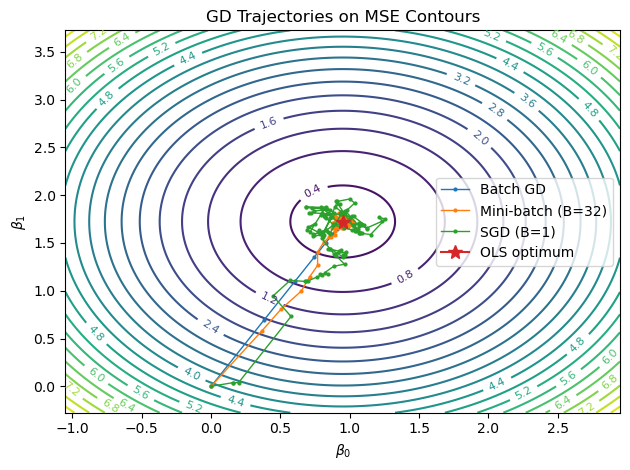

In [17]:
# Plot 1: Contours + trajectories
plt.figure()
cs = plt.contour(B0, B1, Z, levels=20)
plt.clabel(cs, inline=1, fontsize=8)
plt.plot(path_bgd[:,0], path_bgd[:,1], marker='o', markersize=2, linewidth=1, label='Batch GD')
plt.plot(path_mbgd[:,0], path_mbgd[:,1], marker='o', markersize=2, linewidth=1, label='Mini-batch (B=32)')
plt.plot(path_sgd[:,0], path_sgd[:,1], marker='o', markersize=2, linewidth=1, label='SGD (B=1)')
plt.plot([beta_ols[0]], [beta_ols[1]], marker='*', markersize=10, label='OLS optimum')
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.title('GD Trajectories on MSE Contours')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('plots/contours_paths.png', dpi=200)
plt.close()

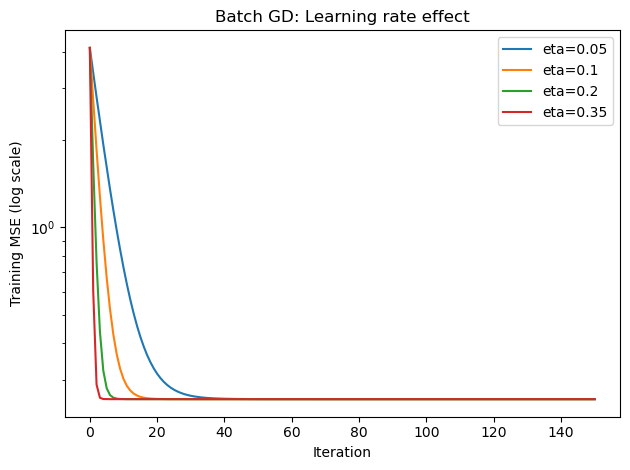

In [18]:

# Plot 2: Loss vs iterations for different learning rates (batch GD)
plt.figure()
for eta in [0.05, 0.1, 0.2, 0.35]:
    p, L = run_gd(eta, 150)
    plt.plot(L, label=f'eta={eta}')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Training MSE (log scale)')
plt.title('Batch GD: Learning rate effect')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('plots/loss_vs_iter_gd.png', dpi=200)
plt.close()



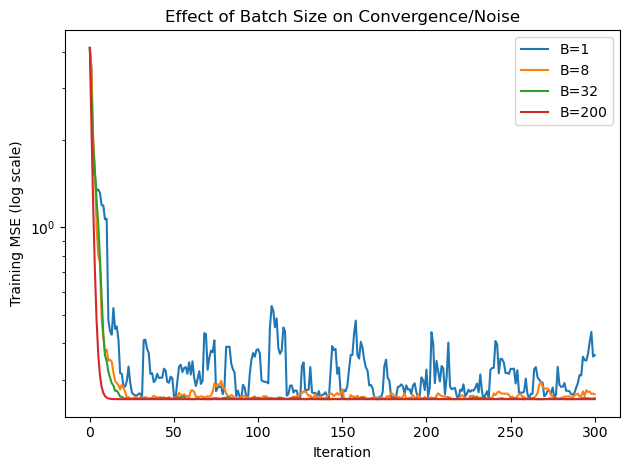

In [19]:
# Plot 3: Loss vs iterations for different batch sizes
plt.figure()
for B in [1, 8, 32, len(y)]:
    # choose eta a bit smaller for noisy estimates
    eta = 0.15 if B == len(y) else 0.08
    _, L = run_minibatch(eta, 300, B=B) if B != len(y) else run_gd(eta, 300)
    plt.plot(L, label=f'B={B}')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Training MSE (log scale)')
plt.title('Effect of Batch Size on Convergence/Noise')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('plots/batch_size_effect.png', dpi=200)
plt.close()

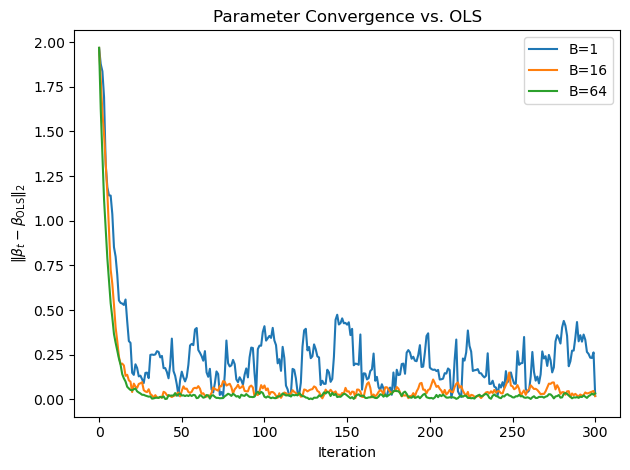

In [20]:
# Plot 4: Parameter distance to OLS over iterations (mini-batch)
plt.figure()
for B in [1, 16, 64]:
    path, L = run_minibatch(0.08, 300, B=B)
    dist = np.linalg.norm(path - beta_ols, axis=1)
    plt.plot(dist, label=f'B={B}')
plt.xlabel('Iteration')
plt.ylabel(r'$\|\beta_t - \beta_{\mathrm{OLS}}\|_2$')
plt.title('Parameter Convergence vs. OLS')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('plots/param_distance.png', dpi=200)
plt.close()